# Consensus network aggregation
- after concat, filter nonsignificant edges with p-values and appropriate threshold of edges ( i filtered with p<0.05 initailly, very roughly)
- count frequency
- meta-analysis using `metap` in R

In [1]:
library(tidyverse)
library(janitor)
library(here)
library(robustbase)
library(metap)
library(igraph)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


here() starts at /home/jiehoonk/crisprscreen


Attaching package: ‘igraph’


The following objects are masked from ‘package:lubridate’:

    %--%, union


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked

In [25]:
files <- list.files(here("tmp/celloracle"), pattern = "*grn.csv$")
grns <- list()

for (file in files) {
  grn <- read_csv(here("tmp/celloracle", file),
                  col_types = cols(source = col_character(), target = col_character(), doner_id = col_character(), .default = col_double())) 
  if (nrow(grn) > 0){
    grns <- append(grns, list(grn))
  }
}

In [26]:
length(files)

[1] 215

In [27]:
grn <- bind_rows(grns) %>% 
  clean_names() %>% 
  mutate(doner_id = as.factor(doner_id))

In [28]:
N <- length(unique(grn$doner_id))
N

[1] 210

# 1. EDA

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 208 rows containing non-finite outside the scale range (`stat_bin()`).”


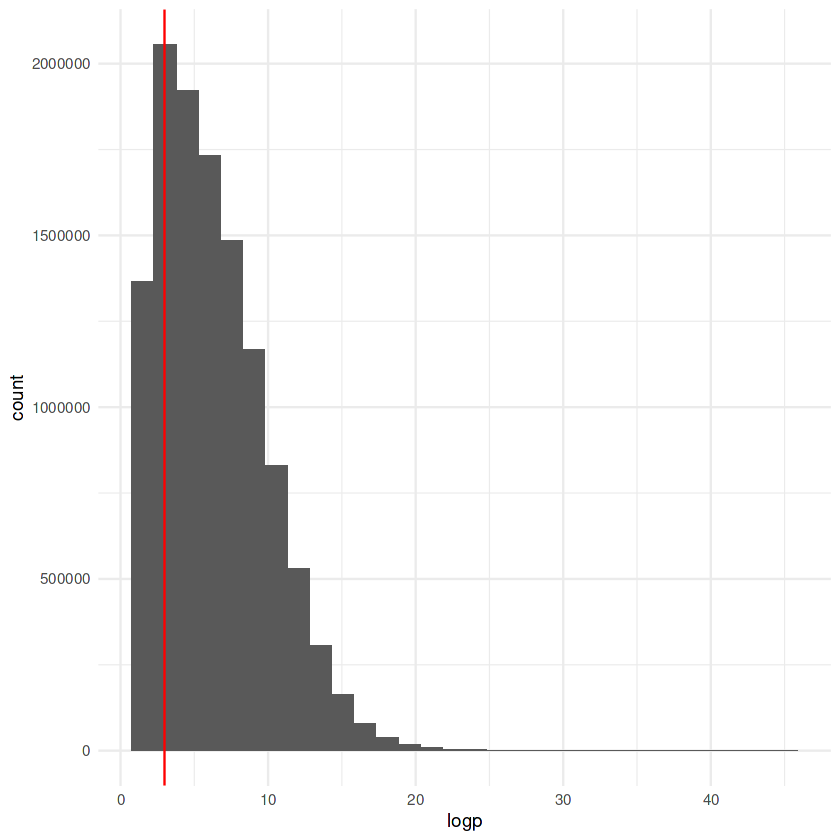

In [29]:
ggplot(grn, aes(x = logp)) + 
    geom_histogram() + 
    geom_vline(xintercept = -log10(0.001), col = "red") + 
    theme_minimal()

In [30]:
grn %>% 
    group_by(doner_id) %>% 
    summarise(
        n = n(),
        n_cells = first(n_cells),
        n_tumor_cells = first(n_tumor_cells)
    ) %>% 
    arrange(desc(n_tumor_cells)) %>% head()

doner_id,n,n_cells,n_tumor_cells
<fct>,<int>,<dbl>,<dbl>
C3N-03184,56038,22695,21875
ndGBM-01,69238,26803,19714
C3N-01816,44340,29634,16391
C3N-01798,43326,23474,14993
C3L-02705,45934,20415,14475
C3N-02188,41178,25685,14400


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


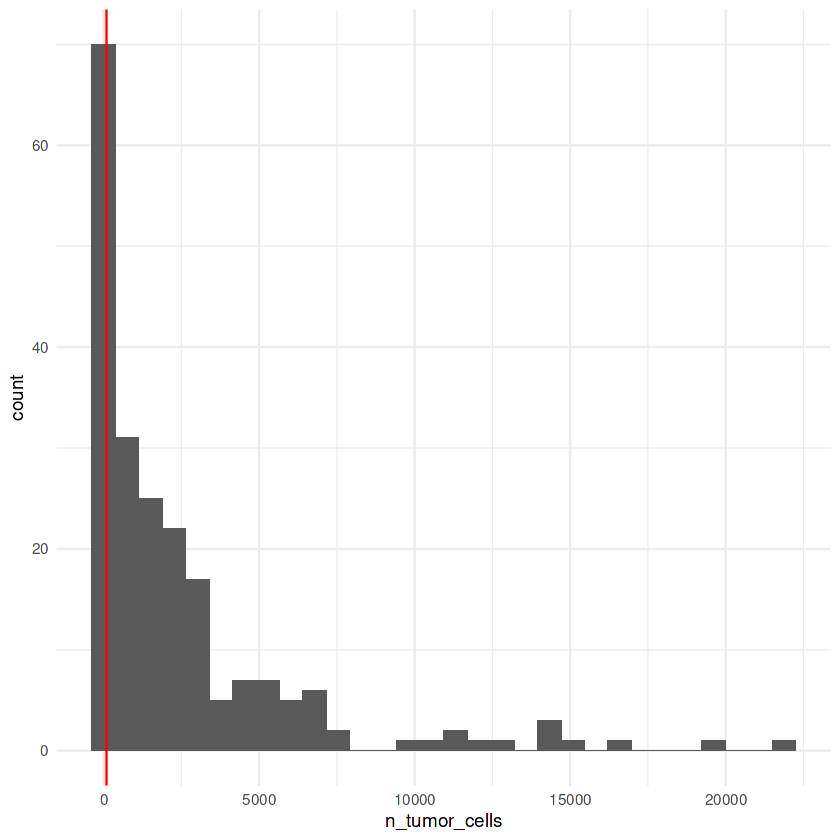

In [31]:
grn %>% 
    group_by(doner_id) %>% 
    summarise(
        n = n(),
        n_cells = first(n_cells),
        n_tumor_cells = first(n_tumor_cells)
    ) %>% 
    ggplot(aes(x = n_tumor_cells)) +
    geom_histogram() +
    geom_vline(xintercept = 100, col = "red") +
    theme_minimal()

# 2. Filter GRN
- weighted mean of edge coefficients : 0.5
## Basic
- tumor proportion > 0.3 (arbitrary), n_tumor_cells >= 50 (arbitrary)
- filter with p-value 0.001
  - do not filter with direction consistency, because it would help when calculating weighted mean
## each TF-gene pair
- n_samples >= N * 0.05 (5%)
- direction_consistency >= 0.8 (arbitrary)
## Final edge filter
- adjusted p-value (BH) < 0.05
- edge coefficient ?

In [100]:
robust_weighted_mean <- function(x, w) {
  w_threshold <- quantile(w, 0.8) # do avoid large dataset distorting the dataset
  w_adjusted <- pmin(w, w_threshold)
  
  w_normalized <- w_adjusted / sum(w_adjusted)
  sum(x * w_normalized)
}

# filter
filtered_grn <- grn %>%
  mutate(
    tumor_proportion = n_tumor_cells / n_cells
  ) %>%
  filter(
    p < 0.001,
    tumor_proportion >= 0.3,
    n_tumor_cells >= 50
  )

In [101]:
# check direction consistency
sign_summary <- filtered_grn %>%
  group_by(source, target) %>%
  summarise(
    n_samples  = n_distinct(doner_id),
    n_positive = sum(coef_mean > 0),
    n_negative = sum(coef_mean < 0),
    .groups    = "drop"
  ) %>%
  mutate(
    direction_consistency = abs(n_positive - n_negative) / n_samples,
    dominant_sign         = if_else(n_positive >= n_negative, "positive", "negative")
  ) %>%
  filter(
    n_samples >= N * 0.1,
    direction_consistency >= 0.8
  )

In [102]:
# filter according to direction
# filtered_sign <- filtered_grn %>%
#   inner_join(sign_summary, by = c("source", "target")) %>%
#   filter(
#     (dominant_sign == "positive" & coef_mean > 0) |
#     (dominant_sign == "negative" & coef_mean < 0)
#  )


filtered_sign <- filtered_grn %>%
  inner_join(sign_summary, by = c("source", "target"))

In [103]:
# 5) Aggregate per edge: robust weighted mean effect size & Fisher’s combined p
final_summary <- filtered_sign %>%
  group_by(source, target, dominant_sign, n_samples, direction_consistency) %>%
  summarise(
    combined_coef   = robust_weighted_mean(coef_mean, n_tumor_cells),
    combined_p      = sumlog(p)$p,               # Fisher’s method
    avg_tumor_prop  = mean(tumor_proportion),    
    .groups = "drop"
  )

In [104]:
# Multiple testing correction (BH)
final_summary <- final_summary %>%
  mutate(adj_p_bonf = p.adjust(combined_p, method = "bonf"),
        adj_p_BH = p.adjust(combined_p, method = "BH")) %>%
  filter(adj_p_BH < 0.05)

In [ ]:

# 7) Final effect-size threshold
# final_summary <- final_summary %>%
#   filter(abs(combined_coef) >= 0.3)

In [82]:
# write_csv(final_summary, here("output", "g.csv"))

# 3. Graph analysis

In [2]:
# final_summary <- read_csv(here("output", "g.csv"))

Rows: 144097 Columns: 10
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): source, target, dominant_sign
dbl (7): n_samples, direction_consistency, combined_coef, combined_p, avg_tumor_prop, adj_p_bonf, adj_p_BH

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [105]:
g <- final_summary %>%
  select(source, target, combined_coef) %>%
  graph_from_data_frame(directed = TRUE)

tfs <- unique(final_summary$source)


## 1. Find cut node (articulation points)

In [106]:
cut_vertices <- articulation_points(g)
cut_vertex_names <- V(g)$name[cut_vertices]

pr_res <- page_rank(g, directed = TRUE, weights = E(g)$weight)

In [111]:
tf_importance <- tibble(
  tf = V(g)$name,
  out_degree = degree(g, mode = "out"),
  in_degree = degree(g, mode = "in"),
  strength_out = strength(g, mode = "out"),
  betweenness = betweenness(g, normalized = TRUE),
  eigencentrality = eigen_centrality(g, directed = TRUE, weights = E(g)$weight)$vector,
  clustering_coef = transitivity(g, type = "local"),
  authority_score = authority_score(g)$vector,
  hub_score = hub_score(g)$vector,
  page_rank = pr_res$vector,
  is_cut_vertex = tf %in% cut_vertex_names,
) %>%
  filter(tf %in% tfs) %>%
  # Scale numeric columns
  mutate(across(where(is.numeric), ~ scale(.) %>% as.vector)) %>%
  mutate(
    # Weighted linear combination example
    regulatory_importance = (
      1 * out_degree +
      1 * eigencentrality +
      1 * hub_score 
      # 1.5 * page_rank
    ) / (1 + 1 + 1) # sum of weights
  ) %>%
  arrange(desc(regulatory_importance))

head(tf_importance, 30)

tf,out_degree,in_degree,strength_out,betweenness,eigencentrality,clustering_coef,authority_score,hub_score,page_rank,is_cut_vertex,regulatory_importance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
KLF6,4.5335291,4.2535953,4.5335291,7.75239121,3.83468296,-0.68262695,2.70473379,5.11112248,3.099304738,TRUE,4.4931115
ATF3,3.6711304,1.9310227,3.6711304,3.48809618,2.45849351,-0.67327023,0.96333955,3.88519498,1.754626137,TRUE,3.3382730
BHLHE40,3.9945299,0.8753079,3.9945299,2.20885184,1.03004800,-0.70175669,0.81244542,4.19050206,0.679632661,TRUE,3.0716933
MEF2C,4.5874290,1.5087367,4.5874290,4.17177212,-0.03017692,-0.74336241,0.46205538,3.78843166,6.469391451,TRUE,2.7818946
MEF2A,2.7763917,1.9310227,2.7763917,3.52606499,1.47626499,-0.61910262,1.70085607,3.13487525,2.430682055,TRUE,2.4625107
POU2F2,4.1562297,-1.0249788,4.1562297,-0.42292815,-0.89094516,-0.74833601,-1.09980264,3.86777146,-0.555072835,TRUE,2.3776853
EGR1,2.3128524,1.5087367,2.3128524,3.46102436,1.82644245,-0.62610913,1.27501456,2.22317077,0.491664598,TRUE,2.1208219
FOS,2.3667523,1.2975938,2.3667523,2.69361874,0.93629323,-0.63494458,1.19233624,2.17018810,0.080940724,TRUE,1.8244112
ETS1,1.8061932,0.8753079,1.8061932,0.84141103,1.32270614,-0.63479176,1.60165596,1.77811605,-0.219982278,TRUE,1.6356718


In [115]:
tf_importance$tf[str_starts(tf_importance$tf, "LEF")]

[1] "LEF1"

In [116]:
tf_importance[tf_importance$tf == "LEF1",]

tf,out_degree,in_degree,strength_out,betweenness,eigencentrality,clustering_coef,authority_score,hub_score,page_rank,is_cut_vertex,regulatory_importance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
LEF1,-0.5546234,-0.3915499,-0.5546234,-0.4050661,-0.5280889,-0.8241342,-0.5187577,-0.5364529,-0.3878953,FALSE,-0.5397217
